In [4]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime
import warnings
warnings.filterwarnings(action='ignore',category=FutureWarning)

In [2]:
!pip install PyPDF2

   ---------------------------------------- 0.0/232.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/232.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/232.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/232.6 kB ? eta -:--:--
   --- ------------------------------------ 20.5/232.6 kB ? eta -:--:--
   ---------- ----------------------------- 61.4/232.6 kB 1.7 MB/s eta 0:00:01
   ---------- ----------------------------- 61.4/232.6 kB 1.7 MB/s eta 0:00:01
   --------------- ----------------------- 92.2/232.6 kB 871.5 kB/s eta 0:00:01
   -------------------- ----------------- 122.9/232.6 kB 804.6 kB/s eta 0:00:01
   ------------------------- ------------ 153.6/232.6 kB 766.6 kB/s eta 0:00:01
   ------------------------------- ------ 194.6/232.6 kB 787.7 kB/s eta 0:00:01
   --------------------------------- ---- 204.8/232.6 kB 734.2 kB/s eta 0:00:01
   -------------------------------------- 232.6/232.6 kB 712.6 kB/s eta 0:00:00


In [4]:
import PyPDF2
import io

In [5]:
pdf_url='https://www.eci.gov.in/eci-backend/public/api/download?url=LMAhAK6sOPBp%2FNFF0iRfXbEB1EVSLT41NNLRjYNJJP1KivrUxbfqkDatmHy12e%2FzBiU51zPFZI5qMtjV1qgjFmSC%2FSz9GPIId9Zlf4WX9G%2FyncUhH2YfOjkZLtGsyZ9B56VRYj06iIsFTelbq233Uw%3D%3D'

In [6]:
response=requests.get(pdf_url)
if response.status_code==200:
    print(f"response obtained successfully")
else:
    print(f"error")

ConnectionError: HTTPSConnectionPool(host='www.eci.gov.in', port=443): Max retries exceeded with url: /eci-backend/public/api/download?url=LMAhAK6sOPBp%2FNFF0iRfXbEB1EVSLT41NNLRjYNJJP1KivrUxbfqkDatmHy12e%2FzBiU51zPFZI5qMtjV1qgjFmSC%2FSz9GPIId9Zlf4WX9G%2FyncUhH2YfOjkZLtGsyZ9B56VRYj06iIsFTelbq233Uw%3D%3D (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000208064F2C00>: Failed to resolve 'www.eci.gov.in' ([Errno 11001] getaddrinfo failed)"))

In [32]:
pdf_bytes=io.BytesIO(response.content)
pdf_file=PyPDF2.PdfReader(pdf_bytes)

In [33]:
pages=len(pdf_file.pages)

In [34]:
def text_cleaner(text):
    textList=text.split(' ')
    date=datetime.strptime(textList[0], "%d/%b/%Y")
    name=' '.join(textList[1:-1])
    amount=textList[-1]
    amount=float(amount.replace(",", ""))
    return [date,name,amount]

In [36]:
page=pdf_file.pages[0]
corpus=page.extract_text()
#corpus

In [16]:
dataList=corpus.split('\n')[2:]

In [17]:
df=pd.DataFrame(columns=['date of encashment','party_name','denomination'])

In [18]:
for data in dataList:
    clean_data=text_cleaner(data)
    new_row=pd.Series(clean_data, index=df.columns)
    df=df.append(new_row, ignore_index=True)

In [20]:
#for rest of the pages I have to do it separately because they do not contain field names.
for i in range(1,pages):
    page=pdf_file.pages[i]
    corpus=page.extract_text()
    dataList=corpus.split('\n')
    for data in dataList:
        clean_data=text_cleaner(data)
        new_row=pd.Series(clean_data, index=df.columns)
        df=df.append(new_row, ignore_index=True)

In [21]:
df.shape

(20421, 3)

In [22]:
df.head()

,date of encashment,party_name,denomination
0,2019-04-12,ALL INDIA ANNA DRAVIDA MUNNETRA KAZHAGAM,1000000.0
1,2019-04-12,ALL INDIA ANNA DRAVIDA MUNNETRA KAZHAGAM,1000000.0
2,2019-04-12,ALL INDIA ANNA DRAVIDA MUNNETRA KAZHAGAM,10000000.0
3,2019-04-12,ALL INDIA ANNA DRAVIDA MUNNETRA KAZHAGAM,1000000.0
4,2019-04-12,ALL INDIA ANNA DRAVIDA MUNNETRA KAZHAGAM,1000000.0


In [23]:
party_names=df['party_name'].unique()
donations=pd.DataFrame(columns=['party','total_donations_received'])
print(len(party_names))

27


In [24]:
for name in party_names:
    donations=donations.append(pd.Series([name,df[df['party_name']==name].denomination.sum()],index=donations.columns),ignore_index=True)

In [25]:
from decimal import Decimal
donations['total_donations_received']=donations['total_donations_received'].apply(lambda x: Decimal(x))
donations.sort_values(by='total_donations_received',ascending=False)

,party,total_donations_received
2,BHARTIYA JANTA PARTY,60605111000
10,ALL INDIA TRINAMOOL CONGRESS,16095314000
3,"PRESIDENT, ALL INDIA CONGRESS COMMITTEE",14218655000
1,BHARAT RASHTRA SAMITHI,12147099000
18,BIJU JANATA DAL,7755000000
7,DMK PARTY IN PARLIAMENT,6390000000
6,YSR CONGRESS PARTY (YUVAJANA SRAMIKA R,3370000000
5,TELUGU DESAM PARTY,2188800000
4,SHIVSENA (POLITICAL PARTY),1583814000
12,RASTRIYA JANTA DAL,725000000


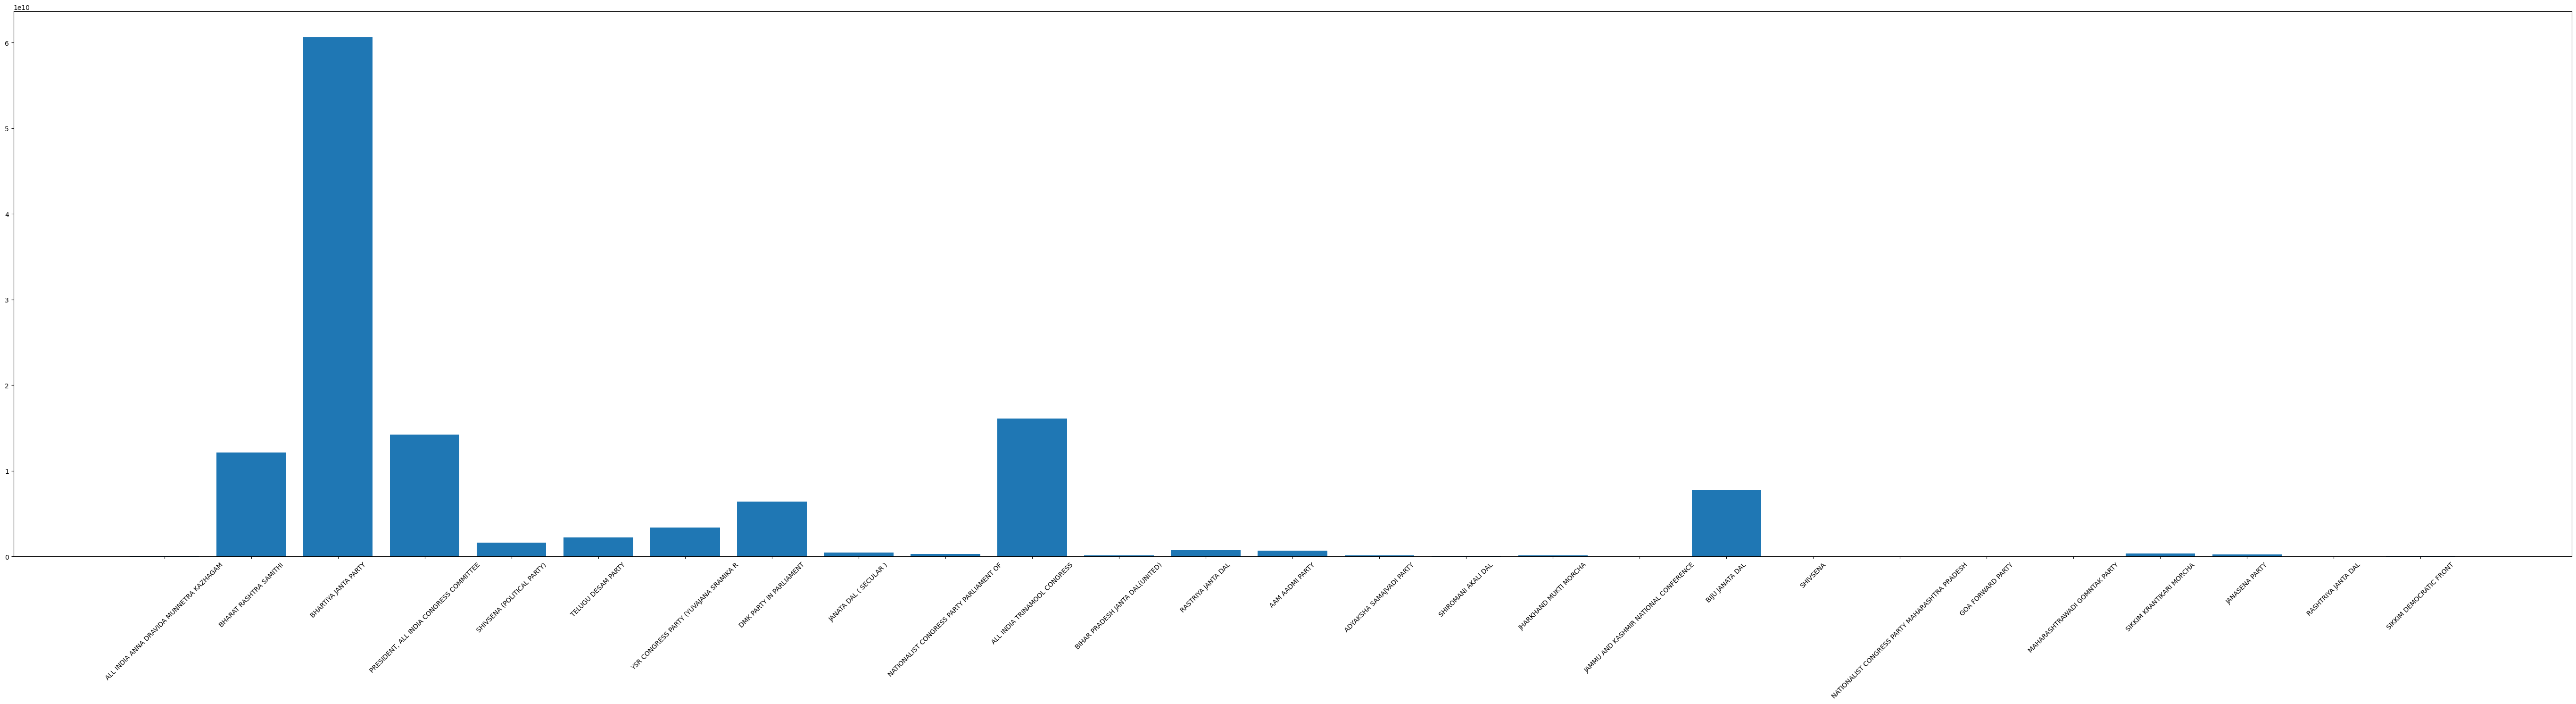

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(70,15))
plt.bar(x=donations['party'],height=donations['total_donations_received'])
plt.xticks(rotation=45);

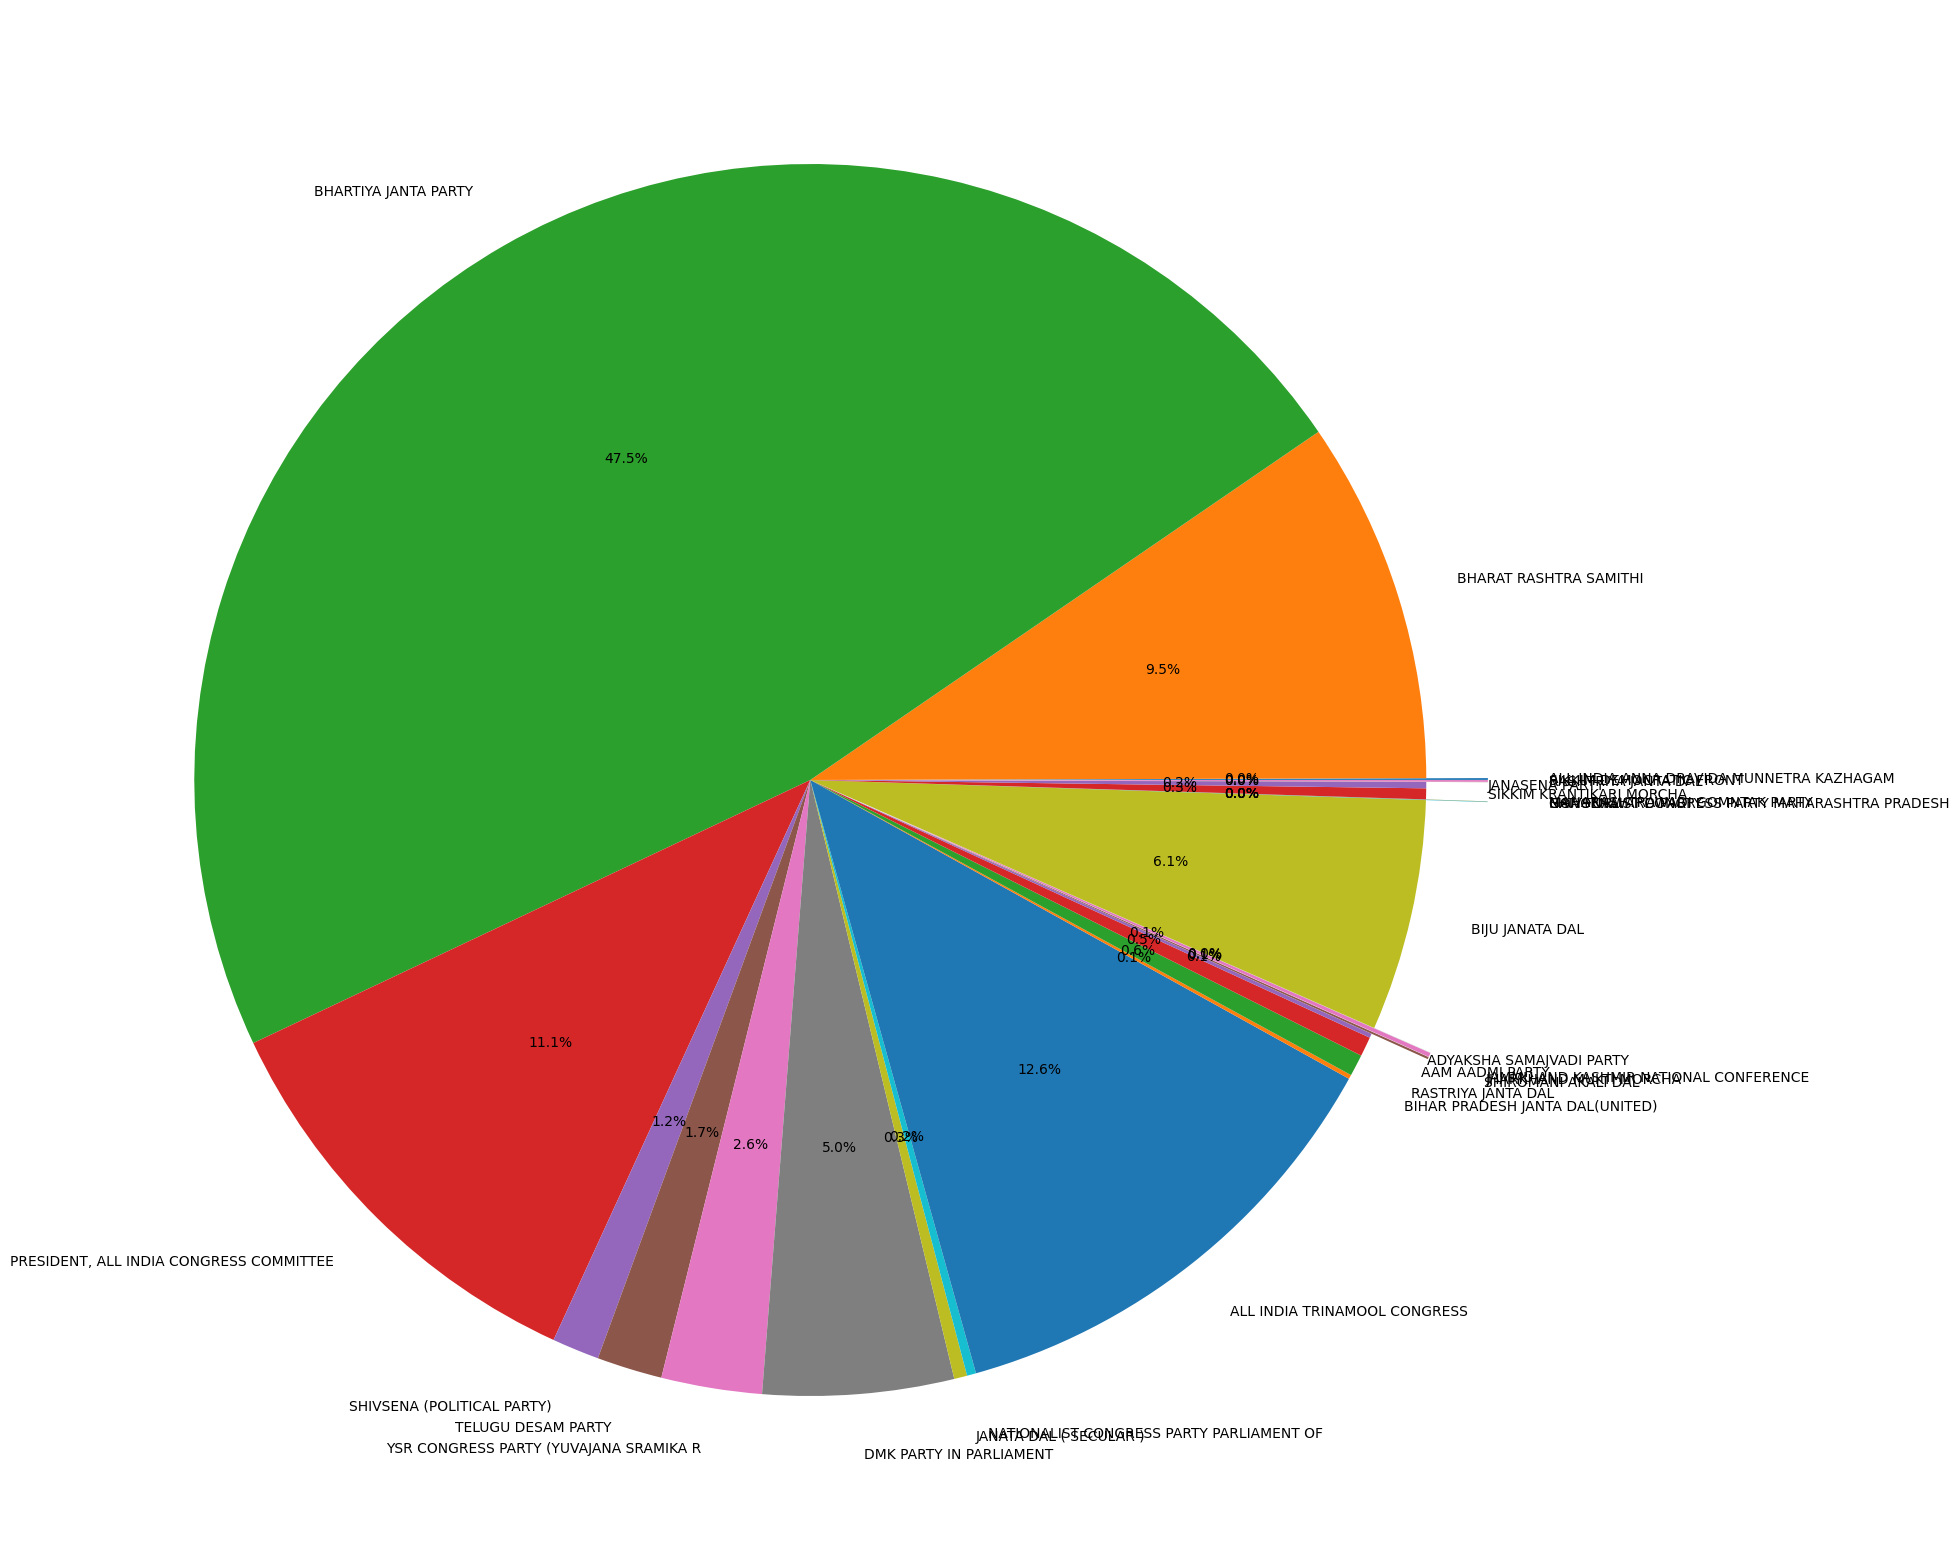

In [282]:
labels = donations['party']
sizes = donations['total_donations_received']
top_5_indexes = donations.sort_values(by='total_donations_received', ascending=False).index[-10:]
explode = [0.1 if i in top_5_indexes else 0 for i in range(len(labels))]
plt.figure(figsize=(30,20))
plt.pie(x=sizes,
        labels=labels,
        explode=explode,
        autopct='%1.1f%%');